In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date, timedelta

In [2]:
# ───────────────
# Task 1: load data & fit trend + seasonality
# ───────────────
df = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])
df = df.sort_values('Dates').reset_index(drop=True)
prices = df['Prices'].astype(float).values

In [3]:
# define start/end dates
start_date = df['Dates'].iloc[0].date()
end_date   = df['Dates'].iloc[-1].date()

In [4]:
# build list of month-end dates and day-counts
months = []
year, month = start_date.year, start_date.month
while True:
    # last day of this month
    this_end = (date(year, month, 1) + timedelta(days=31)).replace(day=1) - timedelta(days=1)
    months.append(this_end)
    if this_end == end_date:
        break
    month = month % 12 + 1
    if month == 1:
        year += 1

days_from_start = np.array([(d - start_date).days for d in months])

In [5]:
# 1a) Linear trend fit
def simple_regression(x, y):
    xbar, ybar = x.mean(), y.mean()
    slope = ((x - xbar)*(y - ybar)).sum() / ((x - xbar)**2).sum()
    intercept = ybar - slope*xbar
    return slope, intercept

slope, intercept = simple_regression(days_from_start, prices)

In [6]:
# 1b) Extract residuals and fit one-year seasonality
residuals = prices - (slope*days_from_start + intercept)
omega     = 2 * np.pi / 365.0
sin_t     = np.sin(days_from_start * omega)
cos_t     = np.cos(days_from_start * omega)

def bilinear_regression(y, x1, x2):
    a = (y*x1).sum() / (x1*x1).sum()
    b = (y*x2).sum() / (x2*x2).sum()
    return a, b

u, w      = bilinear_regression(residuals, sin_t, cos_t)
amplitude = np.hypot(u, w)
phase     = np.arctan2(w, u)

In [7]:
# 1c) Interpolation/extrapolation function
def interpolate(dt):
    d = pd.to_datetime(dt).date()
    t = (d - start_date).days
    trend = slope*t + intercept
    seas  = amplitude * np.sin(omega*t + phase)
    return trend + seas


In [8]:
# ───────────────
# Task 2: storage-contract pricer
# ───────────────
def price_storage_contract(
    inject_dates,           # list of injection date strings
    withdraw_dates,         # list of withdrawal date strings
    volumes,                # list of volumes (same length)
    storage_cost_per_month, # e.g. 100_000 ($100K/mo)
    inj_wdr_cost_per_volume,# e.g. 10_000  ($10K per unit)
    transport_cost_per_volume # e.g. 50_000 ($50K per unit each way)
):
    total = 0.0
    for inj, wdr, vol in zip(inject_dates, withdraw_dates, volumes):
        buy_p  = interpolate(inj)
        sell_p = interpolate(wdr)
        leg_pnl = (sell_p - buy_p) * vol

        days   = (pd.to_datetime(wdr) - pd.to_datetime(inj)).days
        months = days / 30.0

        storage_fee   = storage_cost_per_month * months
        inj_wdr_fee   = inj_wdr_cost_per_volume * vol
        transport_fee = transport_cost_per_volume * vol * 2

        total += leg_pnl - storage_fee - inj_wdr_fee - transport_fee

    return total

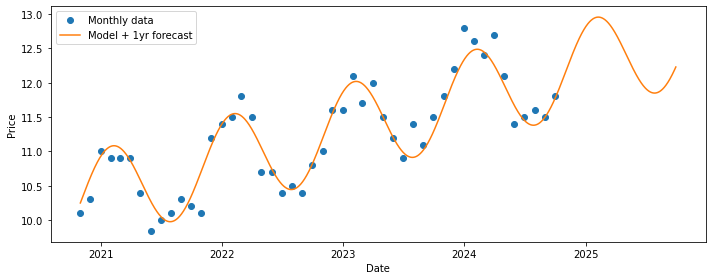

Net contract value: $-109,999,262,670


In [9]:
# ───────────────
# Example: visualize & test
# ───────────────
if __name__ == '__main__':
    # a) plot historical vs. model + forecast
    all_days = pd.date_range(start=start_date, end=end_date + timedelta(days=365), freq='D')
    plt.figure(figsize=(10,4))
    plt.plot(df['Dates'], prices, 'o', label='Monthly data')
    plt.plot(all_days, [interpolate(d) for d in all_days], '-', label='Model + 1yr forecast')
    plt.xlabel('Date'); plt.ylabel('Price'); plt.legend(); plt.tight_layout()
    plt.show()

    # b) single-leg valuation
    inj = ['2024-06-30']
    wdr = ['2024-12-31']
    vol = [1_000_000]   # MMBtu
    sc  = 100_000       # $100K/month
    iw  = 10_000        # $10K per MMBtu
    tc  = 50_000        # $50K per MMBtu each way

    val = price_storage_contract(inj, wdr, vol, sc, iw, tc)
    print(f'Net contract value: ${val:,.0f}')